In [17]:
import random
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


from network_handler import Network_Handler
from network import Network
from person import Person
from disease_propagator import Disease_Propagator
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Parameters
population_size = 1000
average_degree = 5 #Number of initial connections #Distribution

random_edge_probability = 0.1
contact_probability = 0.7 # make distribution?
maximum_contact_number = 3

time_limit = 500
unit_time = population_size # number of simulation steps that make up one time step

time_until_quarantine = {
    'mean': 4+3,
    'std_dev': 2
}
time_until_recovery = 10
p = 0.1 # Factor for probability to become infected in public

Create our networks, first we create a base network, than the random reduction case and finally the triadic strategy case.

In [30]:
population_IDs = range(population_size)

# Network
# Degrees ranging from 3 to 10
# Clustering coefficient: between 0.15 and 0.2 
# Average shortest path length around 6
# -> Typical for social networks [Networks: An Introduction by Newman, my google sheet]

network_base = Network(population_size,average_degree,random_edge_probability, contact_probability)

# Init our networkhandler with the base_network we defined above
network_handler = Network_Handler(network_base)

# Randomly reduced network
network_randomly_reduced = network_handler.random_reduction()

# Reduced network with triadic strategy
network_triadic = network_handler.triadic_strategy()

# Repeating contacts
network_repeating = network_handler.repeating_contacts(network_base, maximum_contact_number)

network = {"base":network_base,
          "randomly_reduced":network_randomly_reduced,
          "triadic":network_triadic,
          "repeating contacts": network_repeating}

We can see that the different networks have different edges...

In [31]:
print(len(list(network_base.edges)))
print(len(list(network_randomly_reduced.edges)))
print(len(list(network_triadic.edges))) 
print(len(list(network_repeating.edges))) 

2000
1312
1281
952


 Next we create the object that is responsible for simulating disease transmission on a given network.

In [32]:
disease = Disease_Propagator(time_limit, time_until_recovery, time_until_quarantine['mean'], time_until_quarantine['std_dev'])


In [33]:
#Loop over every of our networks... maybe implement that into the network handler
S_t = {}
I_t = {}
for key in network.keys():
    S_t[key], I_t[key] = disease.simulate(network[key], p, 25)
    
# perhaps we should make averages over various simulations! 
# For example in the case of edge deletion it can happen, that no one has a contact to infect

Both the suceptible and infectious are highly correlated maybe only plot one of both (todo)

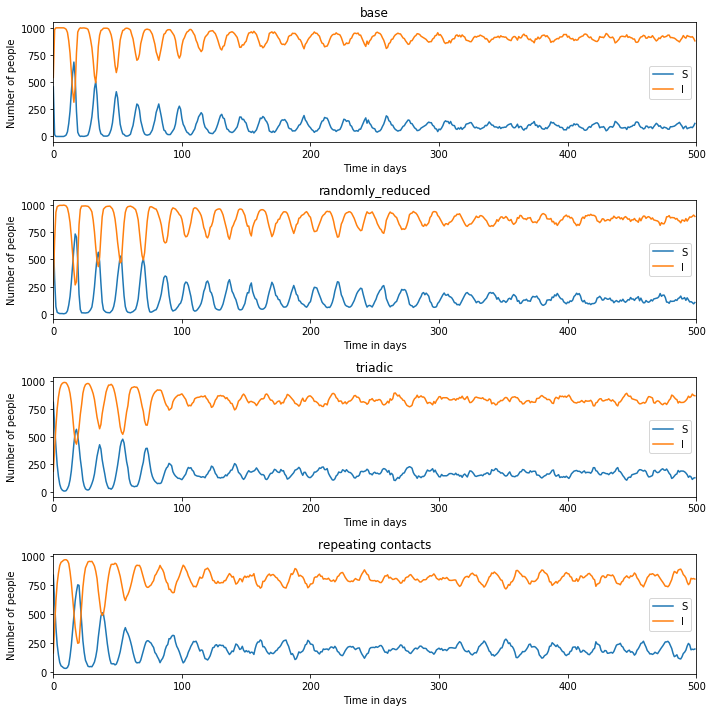

In [34]:
time_range = np.arange(0, time_limit, 1)
fig,ax = plt.subplots(len(network),1,figsize=(10,10))

for i,key in enumerate(network):
    ax[i].set_title(key)
    ax[i].set_xlabel("Time in days")
    ax[i].set_ylabel("Number of people")
    ax[i].set_xlim(0,500)
    ax[i].plot(time_range, S_t[key], label="S")
    ax[i].plot(time_range, I_t[key], label="I")
    ax[i].legend()
plt.tight_layout()

In [27]:
#nx.draw(network["base"],markersize=0.1,alpha=0.1)
#nx.plot()

In [28]:
# just some general testing
network1 = nx.Graph()
network1.add_nodes_from([1,2])
network1.add_edge(1,2)
network2 = network1.copy()
network2.remove_edge(1,2)
network1.edges()
ls = list(network1.edges)
